## Cardiovascular Desease Bayesian Network

### Cardiovascular desease topic
Intro to cardiovascular deasease

### What's a Bayesian Network?
Sprazi di teoria

### Why a Bayesian Network?
Spiegare perché si è scelta

### Dataset
Piccola intro sul dataset

In [48]:
import pandas as pd

# Carica il dataset
df = pd.read_csv('cardio_train.csv', sep=';')

#### Dataset Analysis

Statistiche descrittive

In [27]:
# Visualizza le prime righe del dataset
print(df.head())

# Visualizza le statistiche descrittive del dataset
print(df.describe())

   id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0  
                 id           age        gender        height        weight  \
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000   
mean   49972.419900  19468.865814      1.349571    164.359229     74.205690   
std    28851.302323   2467.251667      0.476838      8.210126     14.395757   
min        0.000000  10798.000000      1.000000

In [29]:
# Controlla la presenza di valori mancanti nel dataset
print(df.isnull().sum())

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [49]:
# Trasformazione della colonna 'age' in anni
df['age'] = (df['age'] / 365).astype(int)

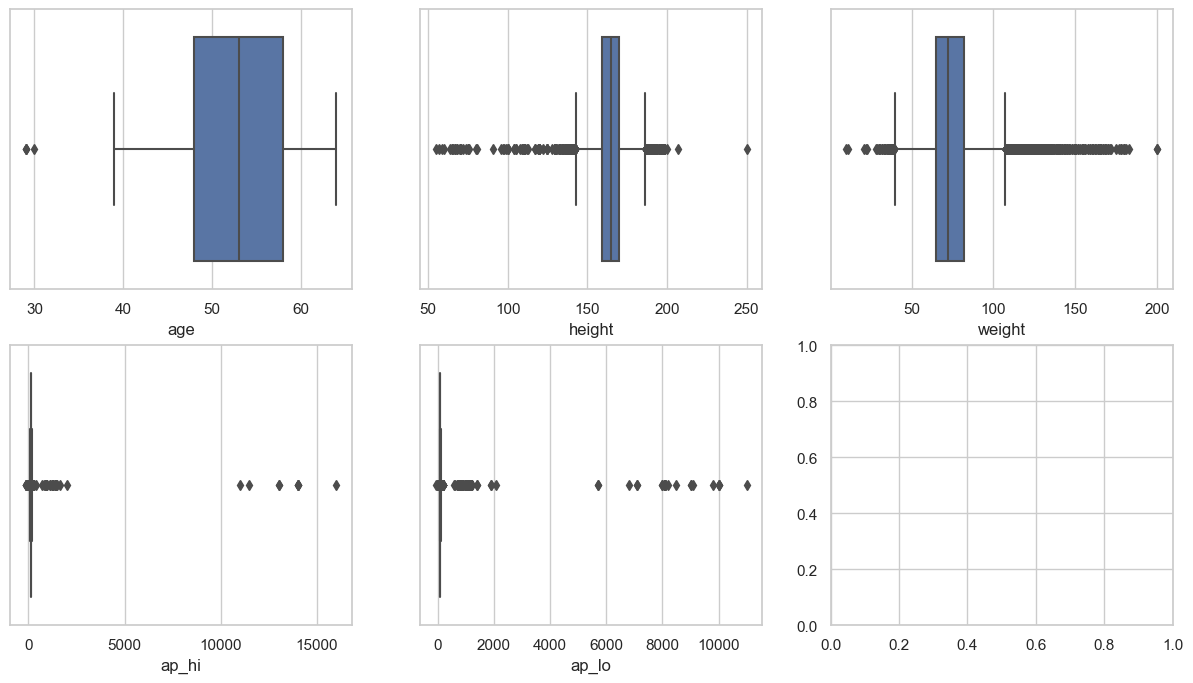

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
# Select the numeric columns
numeric_cols = ["age", "height", "weight", "ap_hi", "ap_lo"]

# Create boxplots for numeric columns
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_xlabel(col)

I boxplot sopra mostrano la presenza di diversi outliers. Considerando il dataset da 70K campioni, è ragionevole ci sia la presenza di alcuni casi particolari legati a condizioni fisiche. Di seguito si utilizza il metodo Interquartile range (IRQ) per analizzare gli outliers dell'altezza.

Number of outliers in height: 519
Outliers in height:
           id  age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  \
62        81   55       2     187   115.0    130     90            1     1   
76       105   55       2     188   105.0    120     80            1     1   
224      309   59       2      76    55.0    120     80            1     1   
249      343   49       1     142    61.0    120     80            1     1   
781     1086   63       1     141    60.0    120     80            1     1   
...      ...  ...     ...     ...     ...    ...    ...          ...   ...   
69430  99172   52       1     140    52.0    150     80            2     1   
69475  99226   52       2     187    73.0    120     80            1     3   
69589  99401   50       2     192    83.0    110     70            1     1   
69784  99673   48       1     141    44.0    100     70            1     1   
69873  99799   54       2     188   108.0    130     80            2     2   

       s

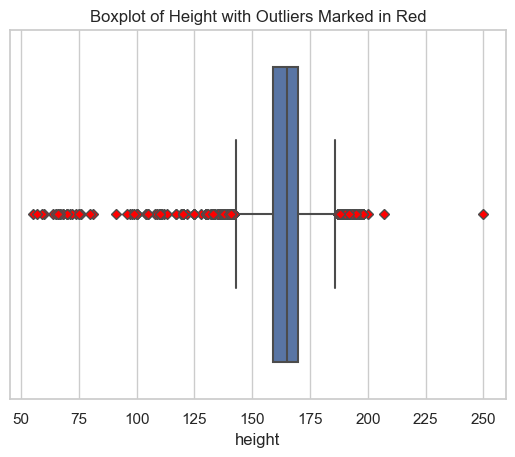

In [64]:
# Calculate the interquartile range (IQR) of the "height" variable
Q1 = df["height"].quantile(0.25)
Q3 = df["height"].quantile(0.75)
IQR = Q3 - Q1

# Calculate the upper and lower bounds for outliers
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

# Find the outliers in the "height" variable
outliers = df[(df["height"] < lower_bound) | (df["height"] > upper_bound)]

# Print the number of outliers and their values
print("Number of outliers in height:", len(outliers))
print("Outliers in height:\n", outliers)
#outliers.to_csv('height_outliers.csv', index=False)

# Create boxplot with expanded x-axis ticks and red diamond outliers
ax = sns.boxplot(x="height", data=df, flierprops={'markerfacecolor': 'red', 'marker': 'D'})
ax.set_title("Boxplot of Height with Outliers Marked in Red")

plt.show()


Per ora si è deciso di mantenere gli outliers.

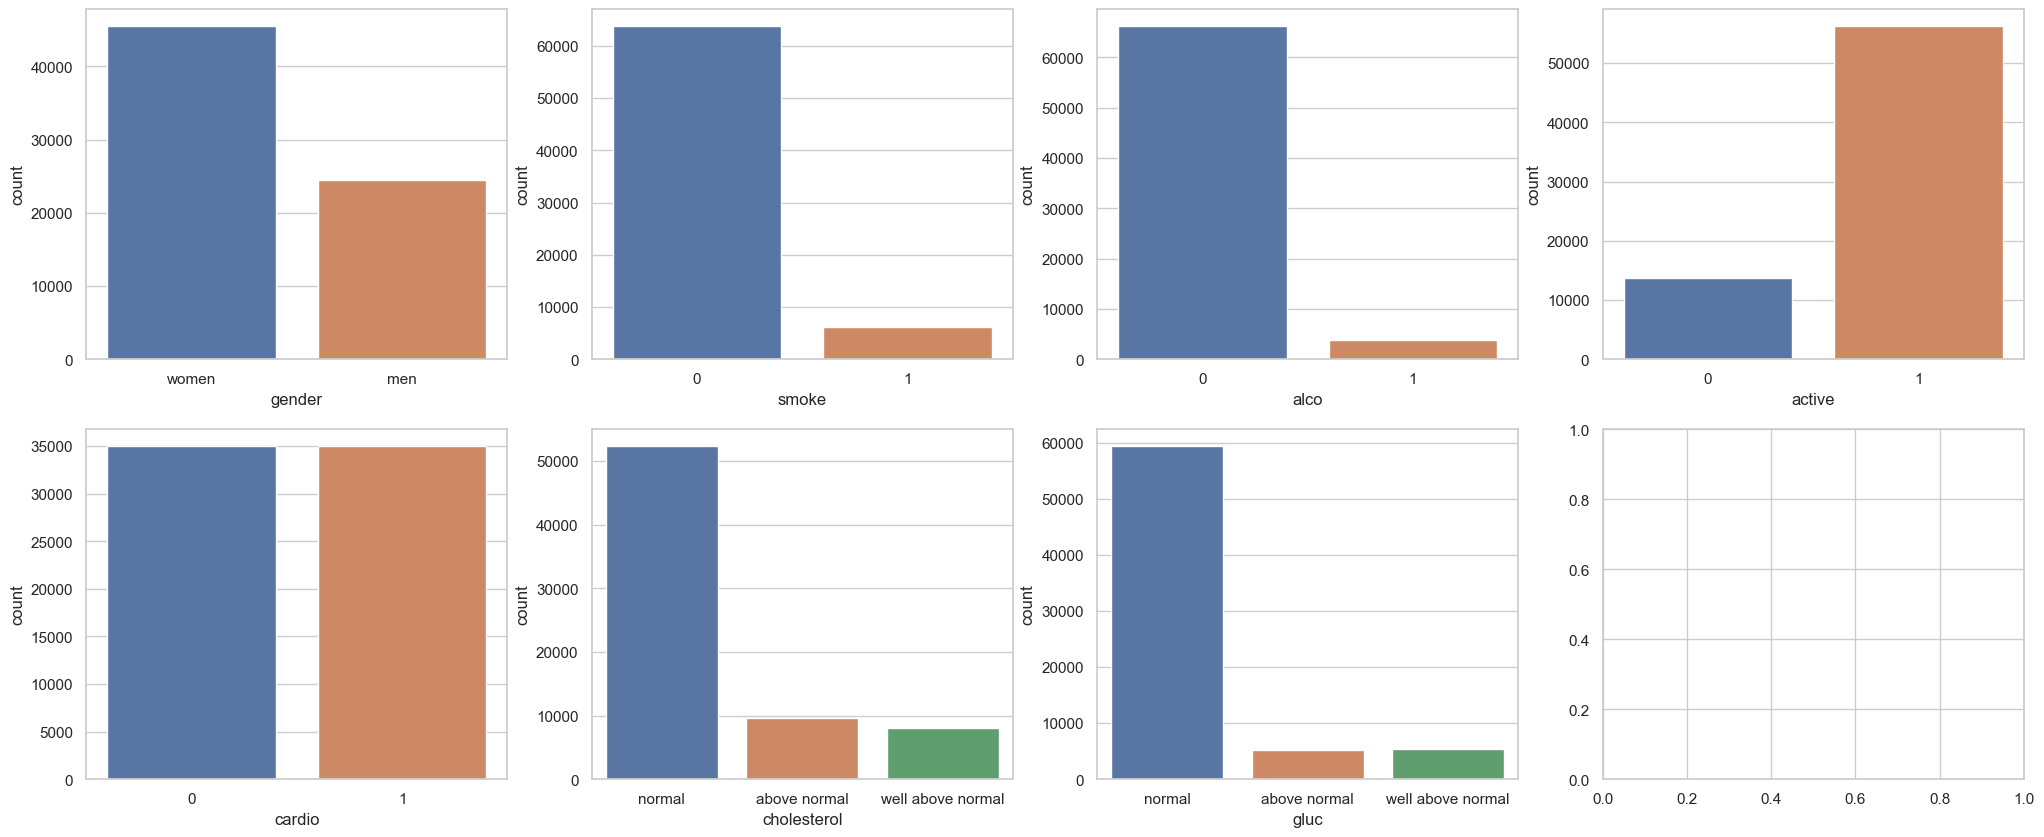

In [39]:
# Create bar charts for binary and categorical columns
binary_cols = ["gender", "smoke", "alco", "active", "cardio"]
cat_cols = ["cholesterol", "gluc"]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
axes = axes.flatten()

for i, col in enumerate(binary_cols + cat_cols):
    if col == "gender":
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["women", "men"])
    elif col in cat_cols:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xticklabels(["normal", "above normal", "well above normal"])
    else:
        sns.countplot(x=col, data=df, ax=axes[i])
        axes[i].set_xlabel(col)


In [ ]:


# Visualizza la distribuzione delle variabili
sns.set(style="ticks", color_codes=True)
sns.pairplot(df)

# Controlla la correlazione tra le variabili
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

# Seleziona le variabili rilevanti per la rete bayesiana
selected_variables = df[['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']]

# Stima le probabilità condizionate tra le variabili
conditional_probabilities = selected_variables.groupby(['cardio']).mean()
print(conditional_probabilities)


### Build a Bayesian Network

### Output and Test